In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [123]:
# Load the data
# data = pd.read_csv("Scrimmage.csv")
data = pd.read_csv("master_sheet_api.csv")

C:\Users\vivia\AppData\Local\Temp\ipykernel_19412\298825316.py:3: DtypeWarning: Columns (28,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("master_sheet_api.csv")


In [124]:
# 1. Feature Engineering

# # Select relevant features.
# features = ['PitchCall', 'TaggedHitType', 'PlayResult', 'ExitSpeed']

# Try with Angle
features = ['PitchCall', 'TaggedHitType', 'PlayResult', 'ExitSpeed', 'Angle']

filtered_data = data[features].copy()

In [125]:
# 2. Data Preprocessing

filtered_data = filtered_data[~(filtered_data['ExitSpeed'] == 0) & ~(filtered_data['TaggedHitType'] == "Bunt") & ~(filtered_data['PitchCall'] == "BallIntentional")]

# Handle missing values: fill in missing values with Undefined or 0s
filtered_data['PitchCall'] = filtered_data['PitchCall'].fillna("Undefined")
filtered_data['TaggedHitType'] = filtered_data['TaggedHitType'].fillna("Undefined")
filtered_data['PlayResult'] = filtered_data['PlayResult'].fillna("Undefined")
filtered_data['ExitSpeed'] = filtered_data['ExitSpeed'].fillna(0)

# Try with angle
filtered_data['Angle'] = filtered_data['Angle'].fillna(0)

In [128]:
def calculate_pitch_score(row):
    pitch_call = row['PitchCall']
    hit_type = row['TaggedHitType']
    play_result = row['PlayResult']
    exit_speed = row['ExitSpeed']
    launch_angle = row['Angle']

    # Pitch Call Weights
    pitch_call_scores = {
        "BallCalled": -0.5, 
        "Undefined": 0,
        "StrikeCalled": 1,
        "InPlay": 0,
        "FoulBall": 0.25,
        "StrikeSwinging": 2,
        "HitByPitch": -2,
        "BallinDirt": -1.5,
        "BallIntentional": -0.5
    }
    
    # Hit Type Weights
    hit_type_scores = {
        "Undefined": 0,
        "LineDrive": -1.5,
        "FlyBall": -1,
        "GroundBall": 0.5,
        "Bunt": 0,
        "Popup": 1
    }
    
    play_result_scores = {
        "Undefined": 0,
        "Single": -1,
        "Double": -1.5,
        "Triple": -2,
        "HomeRun": -3,
        "Out": 0.75,
        "Error": 0.75,
        "FieldersChoice": 0.75,
        "Sacrifice": 0.75
    }
    
    # Exit Speed Scoring
    if exit_speed < 70:
        exit_speed_score = 1.5
    elif 70 <= exit_speed < 80:
        exit_speed_score = 1.5 - (exit_speed - 70) * (0.75 / 10)
    elif 80 <= exit_speed < 90:
        exit_speed_score = 0.75 - (exit_speed - 80) * (0.75 / 10)
    elif 90 <= exit_speed < 100:
        exit_speed_score = 0 - (exit_speed - 90) * (2.5 / 10)
    else:
        exit_speed_score = max(-3, 0 - (exit_speed - 100) * (1.5 / 10))
    
    # Launch Angle Scoring
    if 10 <= launch_angle <= 25:
        angle_score = -1.5
    elif 25 < launch_angle <= 40:
        angle_score = -1
    elif (launch_angle >= 55):
        angle_score = 0.75
    else:
        angle_score = -0.5
        
    total_score = (pitch_call_scores.get(pitch_call, 0) + 
           hit_type_scores.get(hit_type, 0) + 
           play_result_scores.get(play_result, 0) + 
           exit_speed_score + angle_score)
    
    minScore = -9  # Adjusted based on the changes above
    maxScore = 5.25  # Adjusted based on the changes above
    
    # Normalize the total_score to be between 0 and 100
    normalized_score = ((total_score - minScore) / (maxScore - minScore)) * 100
    
    return normalized_score

In [129]:
# Get normalized score and append it to the data
filtered_data['NormalizedScore'] = filtered_data.apply(calculate_pitch_score, axis=1)

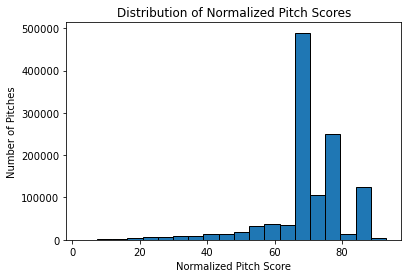

In [130]:
# Plotting the histogram
plt.hist(filtered_data['NormalizedScore'], bins=20, edgecolor='black')
plt.xlabel('Normalized Pitch Score')
plt.ylabel('Number of Pitches')
plt.title('Distribution of Normalized Pitch Scores')
plt.show()

In [131]:
# Filter rows where NormalizedScore is between XX and YY
subset = filtered_data[(filtered_data['NormalizedScore'] >= 95) & (filtered_data['NormalizedScore'] <= 96)]

# Print the desired columns for the filtered rows
for index, row in subset.iterrows():
    print(f"PitchCall: {row['PitchCall']}, ExitSpeed: {row['ExitSpeed']}, TaggedHitType: {row['TaggedHitType']}, PlayResult: {row['PlayResult']}")
    print("-" * 50)  # Just to separate the rows for better readability


In [132]:
# machine learning model imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

print(data.shape)

(1186274, 177)


In [151]:
# 1. Data Preprocessing for all pitches

data['NormalizedScore'] = filtered_data['NormalizedScore']
data = data[:50000]

# features_ml = ['TaggedPitchType', 'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'Tilt', 'RelHeight',
#                'RelSide', 'Extension', 'VertBreak', 'InducedVertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide',
#                'ZoneSpeed', 'VertApprAngle', 'HorzApprAngle', 'ZoneTime', 'EffectiveVelo']
 
# features_ml = ['RelSpeed', 'SpinRate', 'Extension', 'VertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'VertApprAngle']

features_ml = ['RelSpeed', 'InducedVertBreak', 'HorzBreak']
#location is also reliable

# Define the batter result columns separately
batter_result_columns = ['PitchCall', 'TaggedHitType', 'PlayResult', 'ExitSpeed']
all_columns = features_ml + batter_result_columns + ['NormalizedScore']

# Select relevant columns for ml_data
ml_data = data[all_columns]

# Handle missing values - fill with mean or any other appropriate method
ml_data = ml_data.fillna(ml_data.mean())

# Split the data into features and target
X = ml_data[features_ml]
y = ml_data['NormalizedScore']

# 2. Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model Selection and Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# 4. Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

C:\Users\vivia\AppData\Local\Temp\ipykernel_19412\3946633794.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ml_data = ml_data.fillna(ml_data.mean())


Mean Squared Error: 125.46173368496017
R2 Score: 0.024746667810659706


In [152]:
# Assuming your model is already trained
importances = model.feature_importances_
feature_importance_pairs = sorted(zip(features_ml, importances), key=lambda pair: pair[1], reverse=True)
for feature, importance in feature_importance_pairs:
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: PlateLocHeight, Importance: 0.1449
Feature: PlateLocSide, Importance: 0.1430
Feature: HorzBreak, Importance: 0.1220
Feature: VertBreak, Importance: 0.1191
Feature: Extension, Importance: 0.1189
Feature: SpinRate, Importance: 0.1187
Feature: RelSpeed, Importance: 0.1174
Feature: VertApprAngle, Importance: 0.1161


In [135]:
# Print first 200 predictions with batter data
first_200_preds = y_pred[:200]
first_200_actual = y_test[:200].values
first_200_samples = X_test.iloc[:200]
first_200_batter_data = ml_data.loc[first_200_samples.index, batter_result_columns]

for i in range(200):
    pitch_data = " | ".join([f"{col}: {first_200_samples[col].iloc[i]:.2f}" for col in first_200_samples.columns])
    batter_result = " | ".join([f"{col}: {first_200_batter_data[col].iloc[i]}" for col in batter_result_columns])
    print(f"Pitch Data: {pitch_data} | {batter_result} | Prediction: {first_200_preds[i]:.2f} | Actual: {first_200_actual[i]:.2f}")

Pitch Data: RelSpeed: 90.98 | SpinRate: 2293.56 | Extension: 5.62 | VertBreak: -15.68 | HorzBreak: 14.74 | PlateLocHeight: 2.07 | PlateLocSide: 0.59 | PitchCall: InPlay | TaggedHitType: LineDrive | PlayResult: Double | ExitSpeed: 100.25378 | Prediction: 68.11 | Actual: 31.31
Pitch Data: RelSpeed: 92.42 | SpinRate: 2288.04 | Extension: 5.08 | VertBreak: -10.02 | HorzBreak: 8.93 | PlateLocHeight: 2.67 | PlateLocSide: 0.86 | PitchCall: InPlay | TaggedHitType: FlyBall | PlayResult: HomeRun | ExitSpeed: 105.20001 | Prediction: 68.55 | Actual: 22.60
Pitch Data: RelSpeed: 94.67 | SpinRate: 2223.83 | Extension: 5.37 | VertBreak: -8.30 | HorzBreak: 8.82 | PlateLocHeight: 4.14 | PlateLocSide: 0.85 | PitchCall: BallCalled | TaggedHitType: Undefined | PlayResult: Undefined | ExitSpeed: 79.68926331018113 | Prediction: 70.84 | Actual: 66.67
Pitch Data: RelSpeed: 84.36 | SpinRate: 2034.92 | Extension: 5.12 | VertBreak: -29.19 | HorzBreak: 14.87 | PlateLocHeight: 2.94 | PlateLocSide: 0.54 | PitchCall:

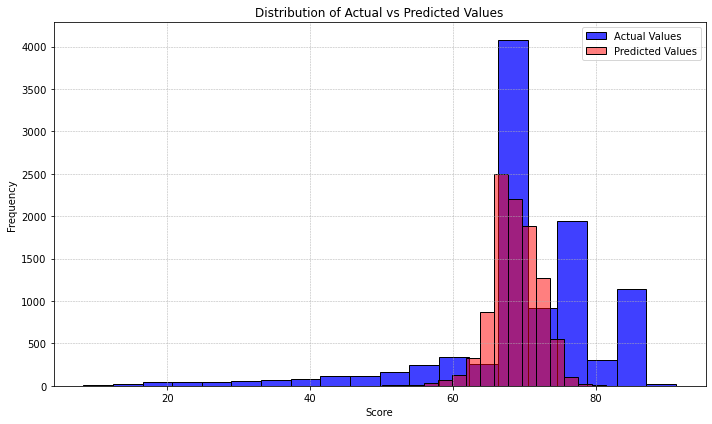

In [153]:
import seaborn as sns

# Sample actual and predicted data
# y_test = [Actual values]
# y_pred = [Predicted values]

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot actual values
sns.histplot(y_test, bins=20, kde=False, color='blue', label='Actual Values')

# Plot predicted values
sns.histplot(y_pred, bins=20, kde=False, color='red', alpha=0.5, label='Predicted Values')

# Decorate the plot
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

In [ ]:
# Ideas
# Get weights of hits/bbs using article
# Get xSLG% based on data
# Maybe just using swinging data
# Maybe separate location/other factors
# wOBA
# r^2 = 0.7 correlation between avg score per nine innings vs. runs allowed/scored per nine innings
# use either balls in play and swings only
# bin expected slugging for balls in play based on exit velocity and launch angle based on our data
# start with linear regression
# location is also reliable